# Open file in Pandas DataFrame

In [21]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
%matplotlib inline
plt.style.use('classic')

In [22]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iravi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# run this cell in if your file is on Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
# run this cell only if data is archived
# !unzip "/content/gdrive/My Drive/Reddit project/all_praw_data.zip" -d "/content/gdrive/My Drive/Reddit project/"

In [5]:
#praw_df = pd.read_csv("/content/gdrive/My Drive/Reddit project/all_praw_data.csv", low_memory=False)  

In [24]:
praw_df = pd.read_csv("all_praw_data.csv", low_memory=False)

# Cleaning and EDA

In [25]:
print("The dataset contains {} rows and {} columns".format(len(praw_df), len(praw_df.columns)))

The dataset contains 3999787 rows and 64 columns


Period of posts in data

In [26]:
start_timestamp = praw_df['created_utc'].min()
end_timestamp = praw_df['created_utc'].max()

start_date = dt.datetime.fromtimestamp(start_timestamp)
end_date = dt.datetime.fromtimestamp(end_timestamp)

print("{} - {}".format(start_date, end_date))

2020-03-14 19:50:49 - 2020-11-30 11:59:52


Number of posts per day

In [27]:
# how many posts per day
def format_epoch(x, format):
    date = dt.datetime.fromtimestamp(x)
    return int(date.strftime(format))

def decode_epoch(data_col, name, format):
    return data_col.apply(lambda x: format_epoch(x, format)).rename(name)

created_utc = praw_df['created_utc']
day_of_year = decode_epoch(created_utc,'day_of_year', "%j")
posts_per_day = day_of_year.value_counts()

In [28]:
#sort by day of year
posts_per_day.sort_index(inplace=True)

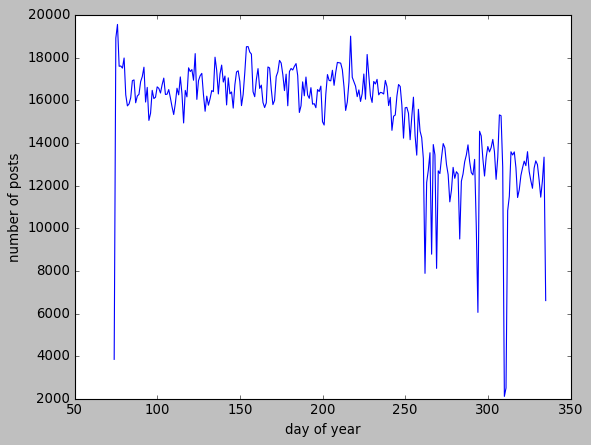

In [29]:
plt.xlabel("day of year")
plt.ylabel("number of posts")
plt.plot(posts_per_day.index, posts_per_day.values)

drop columns which have only one value or all null

In [30]:
columns = list(praw_df.columns)
columns_to_drop = []
for column in columns:
    if len(praw_df[column].unique()) == 1:
        columns_to_drop.append(column)
        
praw_df.drop(columns_to_drop, axis=1, inplace=True) 

Information about the columns

In [43]:
praw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999787 entries, 0 to 3999786
Data columns (total 64 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   _reddit                      object 
 1   selftext                     object 
 2   gilded                       int64  
 3   title                        object 
 4   link_flair_richtext          object 
 5   link_flair_css_class         object 
 6   thumbnail_height             float64
 7   top_awarded_type             object 
 8   name                         object 
 9   link_flair_text_color        object 
 10  upvote_ratio                 float64
 11  ups                          int64  
 12  total_awards_received        int64  
 13  thumbnail_width              float64
 14  link_flair_text              object 
 15  score                        int64  
 16  thumbnail                    object 
 17  edited                       object 
 18  gildings                     object 
 19  

## title

Every post has a title. It might have a text field as well.

In [46]:
def remove_URL(text):
    return re.sub(r"http\S+", "", text)

# returns a list of words
def tokenize_titles(text):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(text)

def clean_text(text_col):
    text_col = text_col.apply(lambda x: remove_URL(x))
    text_col = text_col.apply(lambda x: x.lower())
    text_col = text_col.apply(lambda x: tokenize_titles(x))
    return text_col

def drop_index(data, index):
    data.drop(index, inplace=True)  

In [ ]:
clean_titles = clean_text(praw_df['title']).rename('clean_title')

praw_df = pd.concat([praw_df,clean_titles], axis=1)

# drop posts with only punctuation or emoji
num_of_words = clean_titles.apply(lambda x: len(x))
indices = num_of_words[num_of_words == 0].index

drop_index(praw_df, indices)  
drop_index(num_of_words, indices)
drop_index(clean_titles, indices)

### Post length

In [48]:
num_of_words_str = "number of words in sentence:"
print("Mean {} {}".format(num_of_words_str, math.floor(num_of_words.mean())))
print("Median {} {}".format(num_of_words_str, int(num_of_words.median())))
print("Max {} {}".format(num_of_words_str, num_of_words.max()))

Mean number of words in sentence: 14
Median number of words in sentence: 13
Max number of words in sentence: 146


(array([2.603602e+06, 1.140461e+06, 1.850700e+05, 5.906500e+04,
        1.006400e+04, 2.800000e+01, 1.200000e+01, 2.000000e+00,
        3.000000e+00, 2.000000e+00]),
 array([  1. ,  15.5,  30. ,  44.5,  59. ,  73.5,  88. , 102.5, 117. ,
        131.5, 146. ]),
 <BarContainer object of 10 artists>)

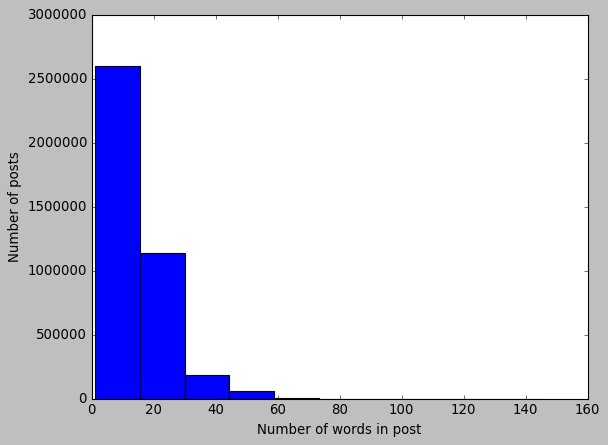

In [49]:
plt.xlabel("Number of words in post")
plt.ylabel("Number of posts")
plt.hist(num_of_words)

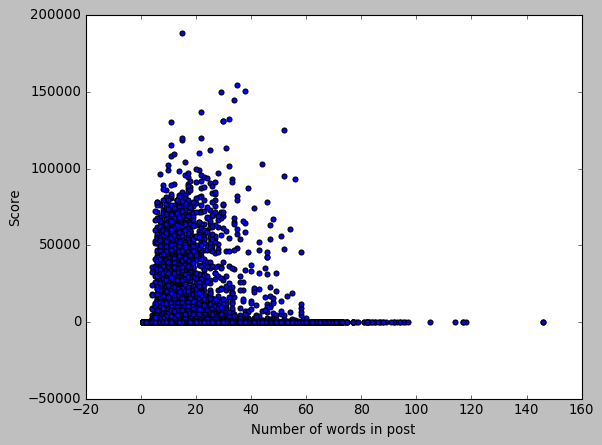

In [50]:
# scatter plot of score as a function of number of words in a sentence
plt.xlabel("Number of words in post")
plt.ylabel("Score")
plt.scatter(num_of_words, praw_df['score'])

We can see that very long sentences get very low scores. 

### Words length

From wikipedia: Longest word in a major dictionary is 45 letters long, and Longest non-contrived and nontechnical word is 28 letters long

In [51]:
def contains_long_words(words, length):
    for word in words:
        if len(word) > length:
            return True
    return False

In [52]:
max_word_length = 28
long_words = clean_titles.apply(lambda x: contains_long_words(x, max_word_length))

In [53]:
clean_titles[long_words[long_words == True].index]

1091       [i, was, sent, this, secret, code, i, can, t, ...
5459       [if, you, could, slap, someone, in, the, face,...
40620      [dear, reddit, nsgayjwjw9283bfjrk420slpapqmr69...
54445      [aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...
59297      [hubert, j, hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh...
                                 ...                        
3880445    [jamshdjdjsjbsbzbsjajksnbsvshssbabsbhdjsjsbsbh...
3891820    [file, home, chronos, u, b2f6182798e7ba38b8481...
3894907    [kwh2jwh, ih, 2, 2, 1, 1, 2, 12, 2, 30, dijwj2...
3943280    [you, get, 10000000000000000000000000000000000...
3972479    [why, eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee...
Name: clean_title, Length: 388, dtype: object

### Lexical diversity

Lexical diversity is the ratio of unique words in a post

In [55]:
def lexical_diversity(text):
    return len(set(text)) / len(text)

lexical_diversity = clean_titles.apply(lambda x: lexical_diversity(x))

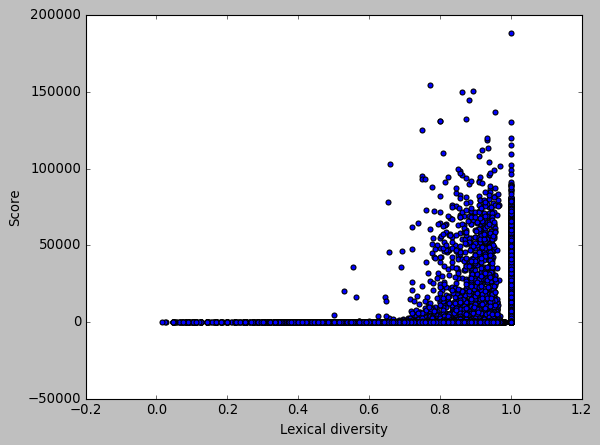

In [56]:
plt.xlabel("Lexical diversity")
plt.ylabel("Score")
plt.scatter(lexical_diversity, praw_df['score'])

We can see here that higher lexical diversity may contribute to a higher score

### common words

In [92]:
def get_most_common_words(words ,num_common_words):
    # Frequency distribution of words in the data
    fdist = FreqDist(words)
    return fdist.most_common(num_common_words)

def titles_to_list(titles):
    list_of_titles = titles.tolist()
    return [item for sublist in list_of_titles for item in sublist]

def remove_stop_words(words, stop_words):
    return [w for w in words if not w in stop_words] 

def get_list_of_words(data,index=None):
    if index is not None:
        clean_titles = data.loc[index, 'clean_title']
    else:
        clean_titles = data['clean_title']
    no_stop_words_titles = clean_titles.apply(lambda x: remove_stop_words(x, english_stop_words))
    return titles_to_list(no_stop_words_titles)

english_stop_words = stopwords.words('english')


#create one list of words from all the titles
flat_list = get_list_of_words(praw_df)
num_common_words = 25
common_words = get_most_common_words(flat_list, num_common_words)

In [60]:
common_words

[('would', 505615),
 ('reddit', 468636),
 ('people', 443127),
 ('thing', 243240),
 ('like', 238944),
 ('one', 218095),
 ('ever', 205641),
 ('life', 181630),
 ('think', 177053),
 ('someone', 168930),
 ('best', 167752),
 ('get', 166148),
 ('something', 159037),
 ('time', 148018),
 ('serious', 138250),
 ('could', 132373),
 ('know', 125227),
 ('good', 110965),
 ('make', 106540),
 ('movie', 90417),
 ('feel', 89573),
 ('worst', 89381),
 ('way', 86699),
 ('person', 85024),
 ('first', 84819)]

## total_awards_received

In [61]:
awarded_posts = praw_df[praw_df['total_awards_received'] > 0]
awarded_posts['total_awards_received'].value_counts().sort_index()

1       16549
2        2052
3         727
4         394
5         278
        ...  
858         1
925         1
940         1
977         1
1115        1
Name: total_awards_received, Length: 298, dtype: int64

(array([2.1226e+04, 1.1700e+02, 7.2000e+01, 3.6000e+01, 1.6000e+01,
        6.0000e+00, 3.0000e+00, 4.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.1240e+02, 2.2380e+02, 3.3520e+02, 4.4660e+02,
        5.5800e+02, 6.6940e+02, 7.8080e+02, 8.9220e+02, 1.0036e+03,
        1.1150e+03]),
 <BarContainer object of 10 artists>)

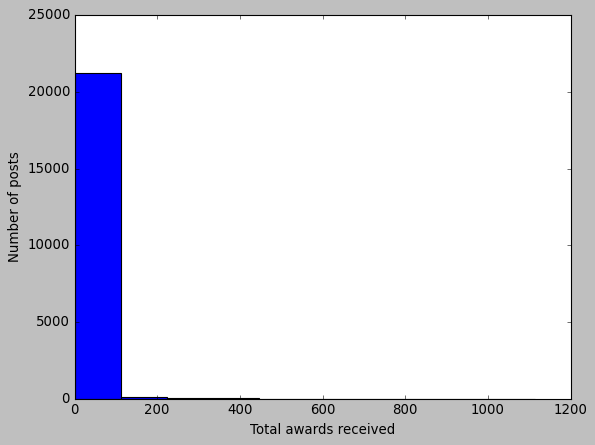

In [62]:
plt.xlabel("Total awards received")
plt.ylabel("Number of posts")
plt.hist(awarded_posts['total_awards_received'])

## link_flair_text

In [63]:
praw_df['link_flair_text'].value_counts()

Serious Replies Only    93974
Modpost                     8
Mega Thread                 7
/r/IAmA Request             1
Breaking News               1
Removed Rule 5              1
Name: link_flair_text, dtype: int64

In [65]:
indices = praw_df[praw_df['link_flair_text'] == "/r/IAmA Request"].index
drop_index(praw_df, indices)


*   Serious Replies Only - the user asks for only serious comments
*   '/r/IAmA Request' - the post was refered to IAmA subreddit
*   'Breaking News' and 'Modpost' are Moderator posts
*   Megathreads are posts about one specific subject. No other posts on this subject are allowed.
*   Removed Rule 5 - post was deleted because it didn't follow rule 5 of AskReddit



## distinguished

In [66]:
moderator_posts = praw_df[praw_df['distinguished'] == 'moderator']
moderator_posts['score'].values

array([76492, 99382, 96762,   565,   432,   574,   760,   691,  1285],
      dtype=int64)

These posts were submitted by AskReddit moderators

In this context they are outliers so I remove them

In [67]:
indices = moderator_posts.index
drop_index(praw_df, indices)

## gildings 

These are different types of gold a post can recieve from users

In [72]:
praw_df[praw_df['gildings'] != '{}']['gildings'].sample(5)

276019    {'gid_1': 1, 'gid_2': 1}
10107                 {'gid_1': 2}
194846                {'gid_1': 1}
121471                {'gid_1': 1}
443308                {'gid_1': 1}
Name: gildings, dtype: object

## upvote_ratio

upvote ratio is the ratio beween upvotes and all the votes (upvotes/upvotes+downvotes)

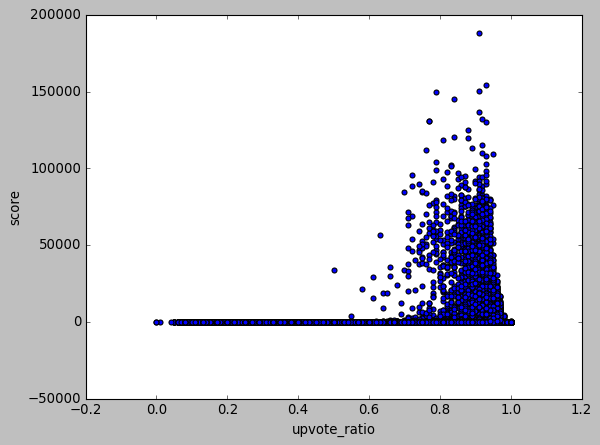

In [73]:
plt.xlabel("upvote_ratio")
plt.ylabel("score")
plt.scatter(praw_df['upvote_ratio'],praw_df['score'])

High score posts get at 70 percent of upvotes. Makes sense 

## score

We are interested in posts with high scores, but they are very uncommon.

In [74]:
lower_bound = 100
higher_score_posts = praw_df[praw_df['score'] > lower_bound]
print("Out of {}, only {} are above {}".format(len(praw_df), len(higher_score_posts), lower_bound))

Out of 3998299, only 11815 are above 100


<AxesSubplot:>

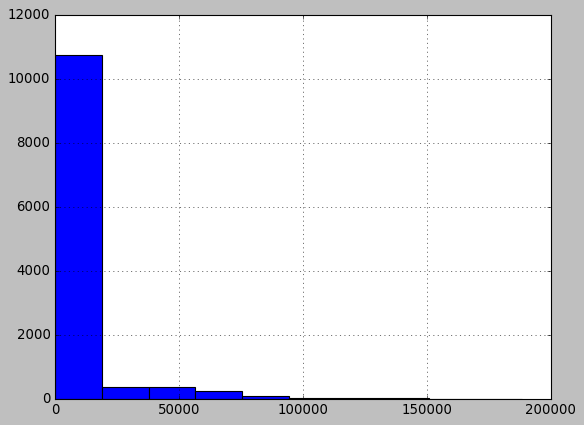

In [75]:
higher_score_posts['score'].hist()

## Drop redundant columns

In [77]:
def drop_column(data, col_name):
    if col_name in data.columns:
        data.drop(col_name, axis=1, inplace=True)


data = praw_df        
drop_column(data, '_reddit')
drop_column(data, 'selftext')
drop_column(data, 'link_flair_richtext')
drop_column(data, 'link_flair_css_class')
drop_column(data, 'top_awarded_type') 
drop_column(data, 'link_flair_text_color')
drop_column(data, 'ups')
drop_column(data, 'thumbnail_width')
drop_column(data, 'is_self')
drop_column(data, 'link_flair_type')  
drop_column(data, 'allow_live_comments')
drop_column(data, 'selftext_html')
drop_column(data, 'suggested_sort')
drop_column(data, 'archived')
drop_column(data, 'treatment_tags')  
drop_column(data, 'treatment_tags')
drop_column(data, 'distinguished')
drop_column(data, 'removal_reason')
drop_column(data, 'link_flair_background_color')
drop_column(data, 'send_replies')  
drop_column(data, 'whitelist_status')
drop_column(data, 'author_flair_text_color')
drop_column(data, 'stickied')
drop_column(data, 'author_flair_richtext')
drop_column(data, 'author_flair_type')  
drop_column(data, 'author_patreon_flair')
drop_column(data, 'link_flair_template_id')
drop_column(data, 'post_hint')
drop_column(data, 'preview')

In [78]:
print("We are left with {} columns".format(len(praw_df.columns)))

We are left with 37 columns


Befor splitting the data we want to remove very low score posts

In [79]:
lower_bound = 50
higher_score_posts = praw_df[praw_df['score'] > lower_bound]
len(higher_score_posts)

18762

# Split the data

In [80]:
week_of_year = decode_epoch(higher_score_posts['created_utc'],'week_of_year', "%U")

I chose to split in the following way: 50% of weeks for test 25% for validation and 25% for test

In [81]:
median = week_of_year.median()
quantile_75 = week_of_year.quantile(0.75)

train_data = higher_score_posts.loc[week_of_year[week_of_year <= median].index,:]
validation_data = higher_score_posts.loc[week_of_year[(week_of_year > median) & (week_of_year < quantile_75)].index,:]
test_data = higher_score_posts.loc[week_of_year[(week_of_year >= quantile_75)].index,:]

In [82]:
num_samples_str = "Number of samples in {} set is: {}"
print(num_samples_str.format('train',len(train_data)))
print(num_samples_str.format('validation',len(validation_data)))
print(num_samples_str.format('test',len(test_data)))

Number of samples in train set is: 9453
Number of samples in validation set is: 4208
Number of samples in test set is: 5101


# Features

## Time features

In [83]:
# this transform features like hour in day to the unit-circle
def encode_cyclic_feature(data, col_name, max_val):
    encoded_data = pd.DataFrame()
    encoded_data[col_name + '_sin'] = np.sin(2 * np.pi * data/max_val)
    encoded_data[col_name + '_cos'] = np.cos(2 * np.pi * data/max_val)
    return encoded_data

In [84]:
def get_hour_of_day(time_col):
    hour_of_day = decode_epoch(time_col, 'hour_of_day', "%H")
    return encode_cyclic_feature(hour_of_day, hour_of_day.name, hour_of_day.max())

In [85]:
def get_day_of_week(time_col):
    day_of_week = decode_epoch(time_col,'day_of_week', "%w")
    return encode_cyclic_feature(day_of_week, day_of_week.name, day_of_week.max())

## Metadata features

Encode boolean features. 0 - False, 1 - True

In [86]:
def get_serious_replies(data):
    return (data['link_flair_text'] == 'Serious Replies Only').astype(int).rename('serious_replies')

In [87]:
def get_over_18(data):    
    # over 18 - "not safe for work"
    return data['over_18'].astype(int)

In [88]:
def get_is_spoiler(data):
    return data['spoiler'].astype(int)

## Textual features

common words in awarded posts

In [99]:
awarded_posts = train_data[train_data['total_awards_received'] > 0]
awarded_titles_flat_list = get_list_of_words(train_data,awarded_posts.index)    

num_common_words = 25
common_words = get_most_common_words(awarded_titles_flat_list, num_common_words)
common_words_list = list(dict(common_words).keys())

In [100]:
common_words_list

['people',
 'reddit',
 'would',
 'thing',
 'ever',
 'serious',
 'like',
 'something',
 'think',
 'life',
 'get',
 'one',
 'time',
 'someone',
 'movie',
 'sex',
 'best',
 'know',
 'person',
 'could',
 'make',
 'made',
 'first',
 'seen',
 'game']

In [101]:
def get_interesting_words_ratio(interesting_words, clean_titles):
    return clean_titles.apply(lambda x: len([w for w in x if w in interesting_words])/len(x)).rename("interesting_words_ratio")

In [102]:
def lexical_diversity(text):
    return len(set(text)) / len(text)

def get_lexical_diversity(clean_titles):
    return clean_titles.apply(lambda x: lexical_diversity(x)).rename("lexical_diversity")

In [103]:
def get_title_length(clean_titles):
    return clean_titles.apply(lambda x: len(x)).rename('title_length')

In [130]:
def get_contains_long_words(clean_titles,length):
    return clean_titles.apply(lambda x: contains_long_words(x, length)).rename('contains_long_words')

In [131]:
def build_features(data):
    hour_of_day = get_hour_of_day(data['created_utc'])
    day_of_week = get_day_of_week(data['created_utc'])
    serious_replies = get_serious_replies(data)
    is_over_18 = get_over_18(data)
    is_spoiler = get_is_spoiler(data)
    interestions_words_ratio = get_interesting_words_ratio(common_words_list, data['clean_title'])
    lexical_diversity = get_lexical_diversity(data['clean_title'])
    length = 15
    contains_long_words = get_contains_long_words(data['clean_title'],length)
    return pd.concat([hour_of_day, day_of_week, serious_replies, is_over_18,
                      is_spoiler, interestions_words_ratio, lexical_diversity,
                      contains_long_words], axis=1)

# Labels

We are not interested in specific score value, rather an estimation of popularity scale.

## Cluster samples by score

In [132]:
from sklearn.cluster import KMeans 

X = train_data['score'].to_numpy()
X = X.reshape(-1, 1)

num_of_clusters = 8 # I compared 5-10 clusters. according to the boxplot with 8 cluster there are the least outliers
KM = KMeans(n_clusters = num_of_clusters, random_state=0) 
KM.fit(X)
labels = pd.DataFrame(KM.labels_, columns=['label'], index=train_data.index)

### Sorted clusters boxplots

<AxesSubplot:>

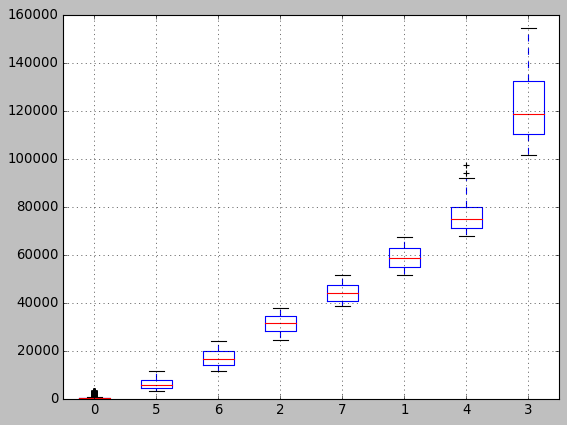

In [133]:
score_label_df = pd.concat([train_data['score'],labels], axis=1)
groups = score_label_df.groupby('label')

sorted_medians = groups['score'].median().sort_values()

sorted_groups_df = pd.DataFrame()
for i in sorted_medians.index:
    group_i = groups.get_group(i)['score'].rename(i)
    sorted_groups_df = pd.concat([sorted_groups_df, group_i], axis=1) 

sorted_groups_df.boxplot()    

In [134]:
group_ranges_df = pd.concat([score_label_df.groupby('label').min()['score'].rename("min"),
                             score_label_df.groupby('label').max()['score'].rename("max")],axis=1)

In [135]:
sorted_group_ranges = group_ranges_df.sort_values(by='min')

In [136]:
def get_label(score):
    for index, row in sorted_group_ranges.iterrows(): 
        if (score >= row["min"]) & (score <= row["max"]):
            return index
    return sorted_group_ranges.tail(1).index.item()

# Oversampling

In [137]:
labels.value_counts()

label
0        8247
5         537
6         215
1         134
7         123
2         117
4          71
3           9
dtype: int64

The groups are unbalanced. A possible solution is to create synthetic data points

In [138]:
X_train = build_features(train_data)

In [139]:
X_train

,hour_of_day_sin,hour_of_day_cos,day_of_week_sin,day_of_week_cos,serious_replies,over_18,spoiler,interesting_words_ratio,lexical_diversity,contains_long_words
1892375,-2.449294e-16,1.000000,-2.449294e-16,1.0,0,0,0,0.222222,1.000000,False
1892694,-2.449294e-16,1.000000,-2.449294e-16,1.0,0,0,0,0.000000,0.850000,False
1892818,-2.449294e-16,1.000000,-2.449294e-16,1.0,0,0,0,0.071429,0.928571,False
1893020,-2.449294e-16,1.000000,-2.449294e-16,1.0,0,1,0,0.200000,1.000000,False
1893265,-2.697968e-01,0.962917,-2.449294e-16,1.0,0,0,0,0.166667,1.000000,False
...,...,...,...,...,...,...,...,...,...,...
3998245,-5.195840e-01,0.854419,-2.449294e-16,1.0,1,1,0,0.133333,1.000000,False
3998317,-5.195840e-01,0.854419,-2.449294e-16,1.0,0,0,0,0.000000,1.000000,False
3999048,-7.308360e-01,0.682553,-2.449294e-16,1.0,0,0,0,0.000000,0.933333,False
3999588,-7.308360e-01,0.682553,-2.449294e-16,1.0,0,0,0,0.052632,0.947368,False


In [140]:
import imblearn
from imblearn.over_sampling import SMOTE

def get_more_samples(X_train, y_train):
    oversample = SMOTE()
    return oversample.fit_resample(X_train, y_train)

X, y = get_more_samples(X_train, labels)   

In [141]:
len(X)

65976

In [142]:
y.value_counts()

label
0        8247
1        8247
2        8247
3        8247
4        8247
5        8247
6        8247
7        8247
dtype: int64

# Train model

In [157]:
from sklearn import metrics

In [158]:
labels_list = list(range(num_of_clusters))
feature_cols = list(X_train.columns)
X_train = X
y_train = y

In [159]:
X_valid = build_features(validation_data)
y_valid = validation_data['score'].apply(lambda x: get_label(x))

In [160]:
def train_model(model,X_train,y_train,X_valid,y_valid,labels_list):
    model.fit(X_train,y_train.values.ravel())
    y_pred = model.predict(X_valid)
    print(metrics.classification_report(y_valid, y_pred, labels=labels_list))

## Decision tree

In [161]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()
train_model(tree_clf,X_train,y_train,X_valid,y_valid,labels_list)

              precision    recall  f1-score   support

           0       0.88      0.76      0.82      3695
           1       0.00      0.00      0.00        54
           2       0.01      0.02      0.01        49
           3       0.00      0.00      0.00        17
           4       0.02      0.02      0.02        47
           5       0.04      0.08      0.05       212
           6       0.02      0.06      0.04        81
           7       0.00      0.00      0.00        53

    accuracy                           0.68      4208
   macro avg       0.12      0.12      0.12      4208
weighted avg       0.78      0.68      0.72      4208



### Most important features

In [162]:
def get_feature_importance(clf):
    return pd.DataFrame(tree_clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)   

In [163]:
get_feature_importance(tree_clf)

,importance
interesting_words_ratio,0.218381
hour_of_day_sin,0.194749
hour_of_day_cos,0.183463
lexical_diversity,0.171624
day_of_week_cos,0.116862
day_of_week_sin,0.087540
over_18,0.021605
serious_replies,0.005435
contains_long_words,0.000258
spoiler,0.000083


## Random Forest

In [164]:
from sklearn.ensemble import RandomForestClassifier
random_forest_clf = RandomForestClassifier(random_state=0)
train_model(random_forest_clf,X_train,y_train,X_valid,y_valid,labels_list)

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      3695
           1       0.00      0.00      0.00        54
           2       0.01      0.02      0.02        49
           3       0.00      0.00      0.00        17
           4       0.03      0.02      0.02        47
           5       0.04      0.08      0.05       212
           6       0.03      0.06      0.04        81
           7       0.01      0.02      0.01        53

    accuracy                           0.71      4208
   macro avg       0.13      0.12      0.12      4208
weighted avg       0.78      0.71      0.74      4208



In [165]:
get_feature_importance(random_forest_clf)

,importance
interesting_words_ratio,0.218381
hour_of_day_sin,0.194749
hour_of_day_cos,0.183463
lexical_diversity,0.171624
day_of_week_cos,0.116862
day_of_week_sin,0.087540
over_18,0.021605
serious_replies,0.005435
contains_long_words,0.000258
spoiler,0.000083


# Test Model

In [166]:
X_test = build_features(test_data)
y_test = test_data['score'].apply(lambda x: get_label(x))

In [167]:
def test_model(model,X_test,y_test,labels_list):
    y_pred = model.predict(X_test)
    print(metrics.classification_report(y_test, y_pred, labels=labels_list))

## Decision tree

In [168]:
test_model(tree_clf, X_test,y_test,labels_list)

              precision    recall  f1-score   support

           0       0.88      0.76      0.81      4465
           1       0.01      0.01      0.01        75
           2       0.01      0.01      0.01        70
           3       0.00      0.00      0.00        25
           4       0.02      0.02      0.02        46
           5       0.06      0.13      0.08       261
           6       0.03      0.07      0.04        98
           7       0.01      0.02      0.01        61

    accuracy                           0.67      5101
   macro avg       0.13      0.13      0.12      5101
weighted avg       0.78      0.67      0.72      5101



## Random Forest

In [169]:
test_model(random_forest_clf, X_test,y_test,labels_list)

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      4465
           1       0.02      0.03      0.02        75
           2       0.01      0.01      0.01        70
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00        46
           5       0.05      0.10      0.06       261
           6       0.03      0.05      0.03        98
           7       0.01      0.02      0.01        61

    accuracy                           0.69      5101
   macro avg       0.12      0.12      0.12      5101
weighted avg       0.77      0.69      0.73      5101

